5. Model Selection: Portfolio Selection using CAPM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from datetime import timedelta

from google.colab import files


 reading a CSV file containing stock return data from a URL into a Pandas DataFrame. And parsing the dates column: process of turning some kind of data into another kind of data.

 The CSV File has returns and risk free rate

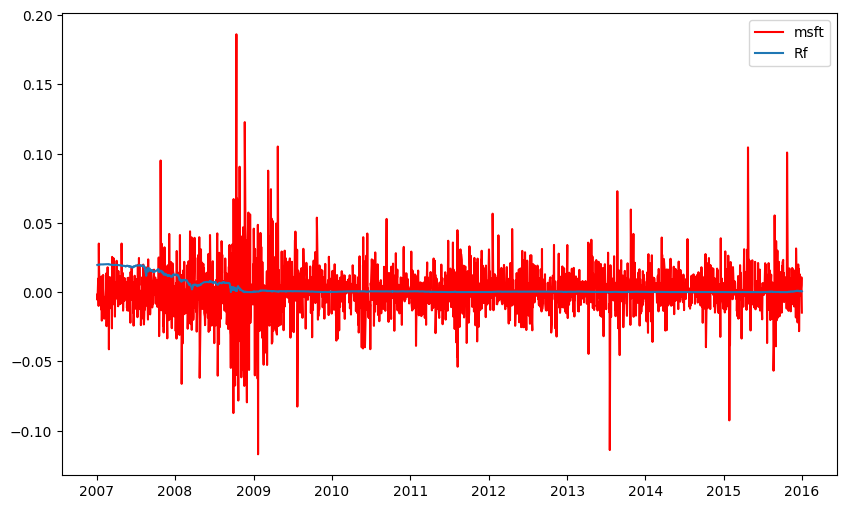

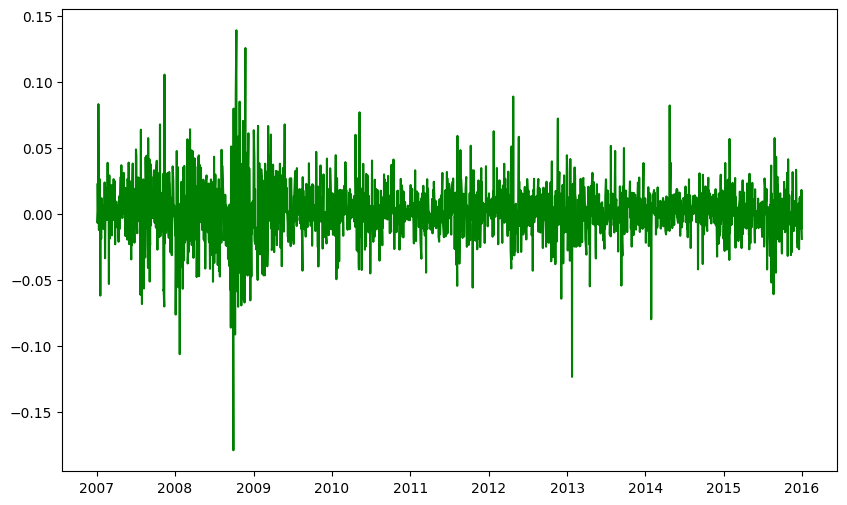

In [ ]:
url = "https://raw.githubusercontent.com/" \
      "StefanHubner/MachineLearningEconomics/" \
      "main/data/stocks/returns.csv"
returns = pd.read_csv(url, parse_dates=['Date'])

plt.figure(figsize=(10, 6))
plt.plot(returns['Date'], returns['msft'], color='red', label='msft')
plt.plot(returns['Date'], returns['Rf'], label='Rf')
plt.plot()
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(returns['Date'], returns['aapl'], color='green', label='msft')



Defining a function to:

*   calculate excess returns for a specified date range.
*   Splits data into train and test sets and returns them as dictionary



In [ ]:
def build_er(from_date, to_date):
  from_date = pd.to_datetime(from_date)
  to_date = pd.to_datetime(to_date)

  def ExcessReturn(offset):
    adjusted_from= from_date + timedelta(days=offset)
    adjusted_to = to_date + timedelta(days=offset)

    ex = returns.copy()
    ex.iloc[:,1:] = ex.iloc[:, 1:].subtract(ex['Rf'], axis=0) # axis means subtraction applied row by row

    #Filtering Rows Based on Date Range
    ex1 = ex[(ex['Date'] >= adjusted_from) & (ex['Date'] <= adjusted_to)]

    #Dropping Unwanted Columns
    ex2= ex1.drop(columns=['Date', 'Rf']).dropna()

    # Selecting all rows except last for training, and all columns
    train = ex2.iloc[:-1, :]
    test = ex2.iloc[-1, :]

    return {'train': train, 'test': test}

  return ExcessReturn









In [ ]:
data = build_er("2014-01-01", "2015-12-31")(0)

file_name1 = 'train_data.xlsx'
file_name2 = 'test_data.xlsx'


data['train'].to_excel(file_name1)
data['test'].to_excel(file_name2)

files.download(file_name1)
files.download(file_name2)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

iloc[] is an index-based selection method, meaning you select rows and columns by their integer positions rather than by their labels. The general structure

ex.iloc[row_indices, column_indices]

#Converting returns between time periods.

np.log(1 + r): This computes the natural logarithm of 1 + r. The reason for adding 1 is to account for the total return (not just the gain).

np.log(1 + r) / 252: Dividing by 252 is because there are typically 252 trading days in a year (the number of trading days in a standard calendar year).

np.exp(...)-1: The exponential of the log is taken to reverse the log transformation. Subtracting 1 adjusts for the fact that the formula was based on the total return, not just the gain.

This formula is based on the assumption that returns are compounded daily. By using the natural logarithm and then exponentiating, this approach accounts for the continuous compounding of returns. More accurate

You might be tempted to directly take the 252nd root of the return: The expression (1 + r) ** (1/252) assumes a linear relationship between the annual return and the daily return.  does not properly account for compound interest or compounding over time, which is the key difference when dealing with financial returns.

In [ ]:
def todaily(r):
  return np.exp(np.log(1 + r) / 252) - 1


def toyearly(mu):
  return (1 + mu) ** 252 - 1

print(toyearly(todaily(0.05)))

0.049999999999971845


Mean Variance Portfolio optimization


 It first converts the annual return into a daily return using the todaily function. Then, it retrieves training and testing data for excess returns via the build er function for a specified date range.

 The function computes the mean vector (mu) and covariance matrix (sigma) of the training data.

Using these, it calculates key constants (a, b, d, and the determinant) and Lagrange multipliers (lambda and nu) to solve for the optimal portfolio weights
(x).

In [ ]:
def mv(r):
  R = todaily(r)
  data = build_er("2014-01-01", "2015-12-31")(0)
  mu = np.mean(data['train'].values, axis=0)
  sigma = np.cov(data['train'].values, rowvar=False)
  sinv = np.linalg.inv(sigma)
  iota = np.ones(len(mu))
  a = np.dot(mu.T, np.dot(sinv, mu))
  b = np.dot(mu.T, np.dot(sinv, iota))
  d = np.dot(iota.T, np.dot(sinv, iota))

  det = a * d - b ** 2
  lambda_ = (d * R - b) / det
  nu = (-b * R + a) / det
  x = np.dot(sinv, lambda_ * mu + nu * iota)
  r_p = np.dot(x.T, data['test'].values)
  mu_p = np.dot(x.T, mu)
  sigma_p = np.sqrt((d * R ** 2 - 2 * b * R + a) / det)
  return {'ins': (mu_p, sigma_p), 'oos': r_p, 'weights': x}



0.049999999999971845


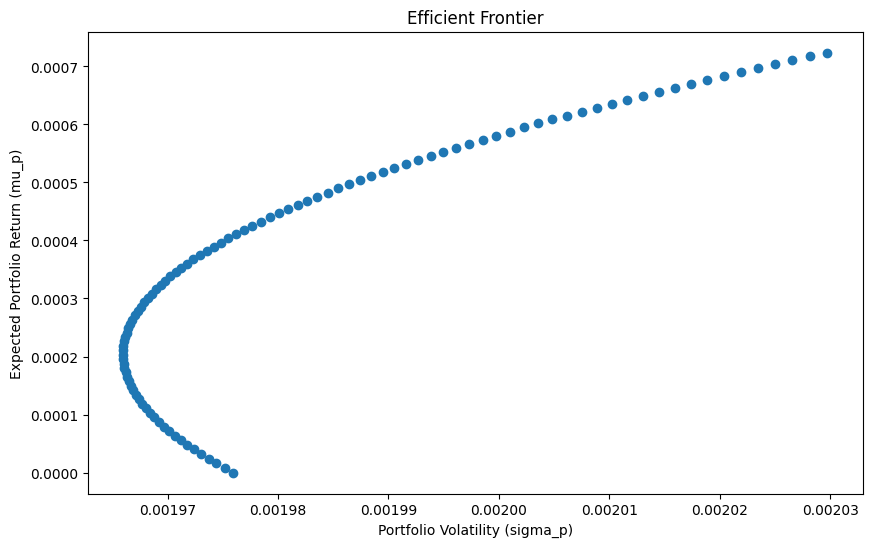

In [ ]:
result = mv(0.05)
mu_p, sigma_p = result['ins']
print(toyearly(mu_p))



mu_p = np.linspace(0, 0.2, 100)
f_ins = np.array([mv(r)['ins'] for r in mu_p])
f_ins_df = pd.DataFrame(f_ins, columns=['mu_p', 'sigma_p'])
plt.figure(figsize=(10, 6))
plt.scatter(f_ins_df['sigma_p'], f_ins_df['mu_p'])
plt.xlabel('Portfolio Volatility (sigma_p)')
plt.ylabel('Expected Portfolio Return (mu_p)')
plt.title('Efficient Frontier')
plt.show()